In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy
from scipy.stats import shapiro

In [2]:
# include points from either side of the intense point
MS1_PEAK_DELTA = 0.1

In [3]:
experiment_base_dir = '/Users/darylwilding-mcbride/Downloads/experiments'
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'

In [4]:
precursor_id = 25950

download the cuboid ZIP file from the Google Cloud Console using the filter 'exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-precursor-{id}-'.

In [5]:
CUBOID_DIR = '/Users/darylwilding-mcbride/Downloads/exp-{}-run-{}-precursor-{}-of-52464'.format(EXPERIMENT_NAME, RUN_NAME, precursor_id)
CUBOID_MS1_FILE = '{}/exp-{}-run-{}-precursor-{}-cuboid-points-ms1-df.pkl'.format(CUBOID_DIR, EXPERIMENT_NAME, RUN_NAME, precursor_id)
CUBOID_METADATA_FILE = '{}/exp-{}-run-{}-precursor-{}-cuboid-metadata.json'.format(CUBOID_DIR, EXPERIMENT_NAME, RUN_NAME, precursor_id)

In [6]:
before_df = pd.read_pickle(CUBOID_MS1_FILE)
before_df['normalised_intensity'] = before_df.intensity / before_df.intensity.max()
metadata_s = pd.read_json(CUBOID_METADATA_FILE, orient='records', typ='series')

In [7]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

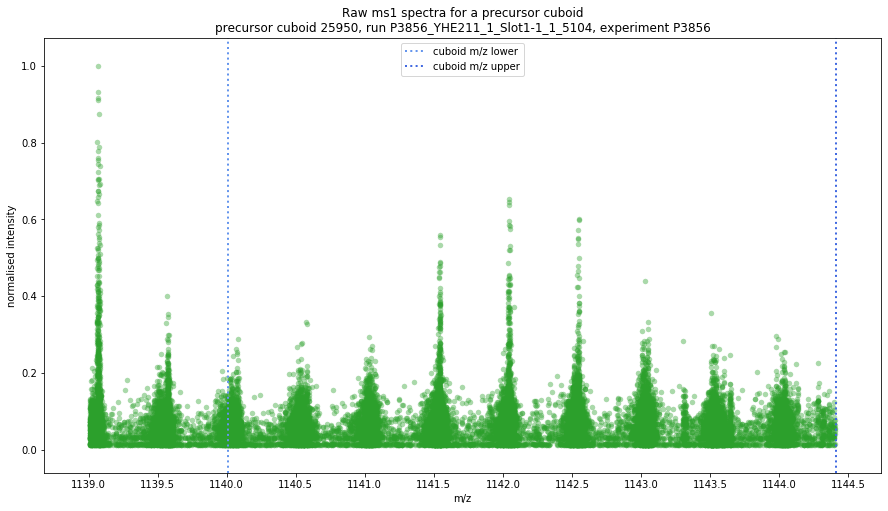

In [8]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

#### perform intensity descent

In [9]:
# fe_raw_points_df = before_df[(before_df.mz >= metadata_s.window_mz_lower) & (before_df.mz <= metadata_s.window_mz_upper) & (before_df.frame_id >= metadata_s.fe_ms1_frame_lower) & (before_df.frame_id <= metadata_s.fe_ms1_frame_upper)]
fe_raw_points_df = before_df[(before_df.mz >= metadata_s.wide_mz_lower) & (before_df.mz <= metadata_s.wide_mz_upper) & (before_df.frame_id >= metadata_s.fe_ms1_frame_lower) & (before_df.frame_id <= metadata_s.fe_ms1_frame_upper)]
fe_raw_points_a = fe_raw_points_df[['mz','intensity']].to_numpy()

In [10]:
def calculate_ms1_peak_delta(mz):
    instrument_resolution = 40000
    delta_m = mz / instrument_resolution  # FWHM of the peak
    sigma = delta_m / 2.35482  # std dev is FWHM / 2.35482. See https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    ms1_peak_delta = 3 * sigma  # 99.7% of values fall within +/- 3 sigma
    return ms1_peak_delta

In [11]:
calculate_ms1_peak_delta(1483)

0.04723290952174688

In [12]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    return ((_int_f/_int_f.sum()) * _mz_f).sum()

In [13]:
# ms1_peaks_a is a numpy array of [mz,intensity]
# returns a numpy array of [mz_centroid,summed_intensity]
def ms1_intensity_descent(ms1_peaks_a, ms1_peak_delta):
    # intensity descent
    ms1_peaks_l = []
    while len(ms1_peaks_a) > 0:
        # find the most intense point
        max_intensity_index = np.argmax(ms1_peaks_a[:,1])
        peak_mz = ms1_peaks_a[max_intensity_index,0]
        peak_mz_lower = peak_mz - ms1_peak_delta
        peak_mz_upper = peak_mz + ms1_peak_delta

        # get all the raw points within this m/z region
        peak_indexes = np.where((ms1_peaks_a[:,0] >= peak_mz_lower) & (ms1_peaks_a[:,0] <= peak_mz_upper))[0]
        if len(peak_indexes) > 0:
            mz_cent = mz_centroid(ms1_peaks_a[peak_indexes,1], ms1_peaks_a[peak_indexes,0])
            summed_intensity = ms1_peaks_a[peak_indexes,1].sum()
            ms1_peaks_l.append((mz_cent, summed_intensity))
            # remove the raw points assigned to this peak
            ms1_peaks_a = np.delete(ms1_peaks_a, peak_indexes, axis=0)
    return np.array(ms1_peaks_l)

In [14]:
peaks_fixed_bins_a = ms1_intensity_descent(fe_raw_points_a, MS1_PEAK_DELTA)
peaks_fixed_bins_df = pd.DataFrame(peaks_fixed_bins_a, columns=['mz','intensity'])
peaks_fixed_bins_df['normalised_intensity'] = peaks_fixed_bins_df.intensity / peaks_fixed_bins_df.intensity.max()

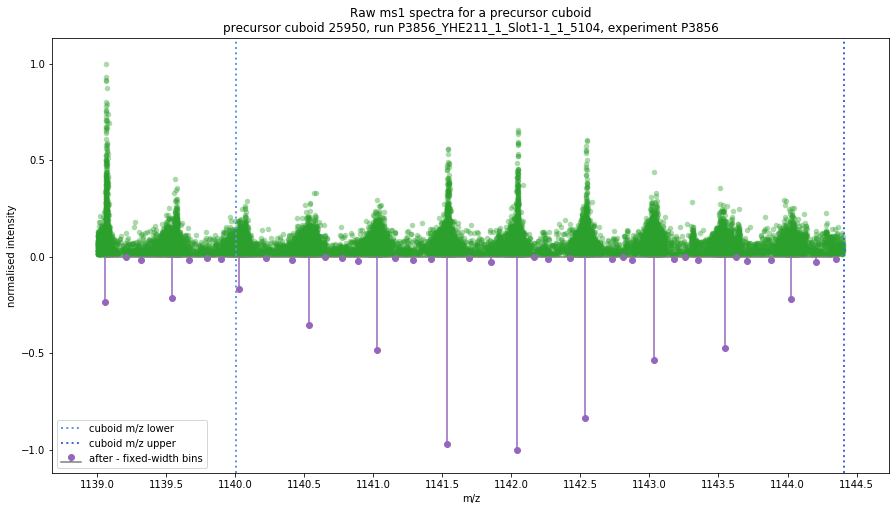

In [15]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

markerline, stemlines, baseline = ax.stem(peaks_fixed_bins_df.mz, -peaks_fixed_bins_df.normalised_intensity, use_line_collection=True, label='after - fixed-width bins')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
plt.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

plt.xlabel('m/z')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

nearest = 0.5
range_l = round(before_df.mz.min() / nearest) * nearest
range_u = round(before_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

# plt.xlim((1481,1482))

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms1 spectra for a precursor cuboid\nprecursor cuboid {}, run {}, experiment {}'.format(precursor_id, RUN_NAME, EXPERIMENT_NAME))
plt.show()

#### plot the features after deconvolution of the fixed-width binned data

In [16]:
ms1_peaks_l = list(map(tuple, peaks_fixed_bins_a))
deconvoluted_peaks, _priority_targets = deconvolute_peaks(ms1_peaks_l, use_quick_charge=True, averagine=averagine.peptide, charge_range=(1,5), error_tolerance=5.0, scorer=scoring.MSDeconVFitter(100.0), truncate_after=0.95)


In [17]:
deconvoluted_peaks[0]

DeconvolutedPeak(a_to_a2_ratio=4.561797988902574, area=26292.0, average_mass=1139.0295817833924, charge=1, chosen_for_msms=False, envelope=[(1139.5412, 9915.00), (1140.5326, 5966.40), (1141.5467, 1.00)], full_width_at_half_max=0.01, index=0|0, intensity=15881.400644756066, most_abundant_mass=1138.5338842971985, mz=1139.5411607639685, neutral_mass=1138.5338842971985, score=116.22028117988097, signal_to_noise=13146.0)

In [18]:
ms1_deconvoluted_peaks_l = []
for peak_idx,peak in enumerate(deconvoluted_peaks):
    # discard a monoisotopic peak that has either of the first two peaks as placeholders (indicated by intensity of 1)
    if ((len(peak.envelope) >= 3) and (peak.envelope[0][1] > 1) and (peak.envelope[1][1] > 1)):
        mono_peak_mz = peak.mz
        mono_intensity = peak.intensity
        second_peak_mz = peak.envelope[1][0]
        ms1_deconvoluted_peaks_l.append((mono_peak_mz, second_peak_mz, mono_intensity, peak.score, peak.signal_to_noise, peak.charge, peak.envelope, peak.neutral_mass))
features_fixed_bins_df = pd.DataFrame(ms1_deconvoluted_peaks_l, columns=['mono_mz','second_peak_mz','intensity','score','SN','charge','envelope','neutral_mass'])

In [19]:
features_fixed_bins_df

,mono_mz,second_peak_mz,intensity,score,SN,charge,envelope,neutral_mass
0,1139.541161,1140.532556,15881.400645,116.220281,13146.000000,1,"((1139.5412, 9915.00), (1140.5326, 5966.40), (...",1138.533884
1,1141.537352,1142.039419,175872.000000,673.160835,35174.400000,2,"((1141.5374, 44766.00), (1142.0394, 46049.00),...",2281.060152
2,1139.781147,1140.031986,48122.000000,182.904028,6874.571429,4,"((1139.7946, 360.00), (1140.0320, 7727.00), (1...",4555.095481


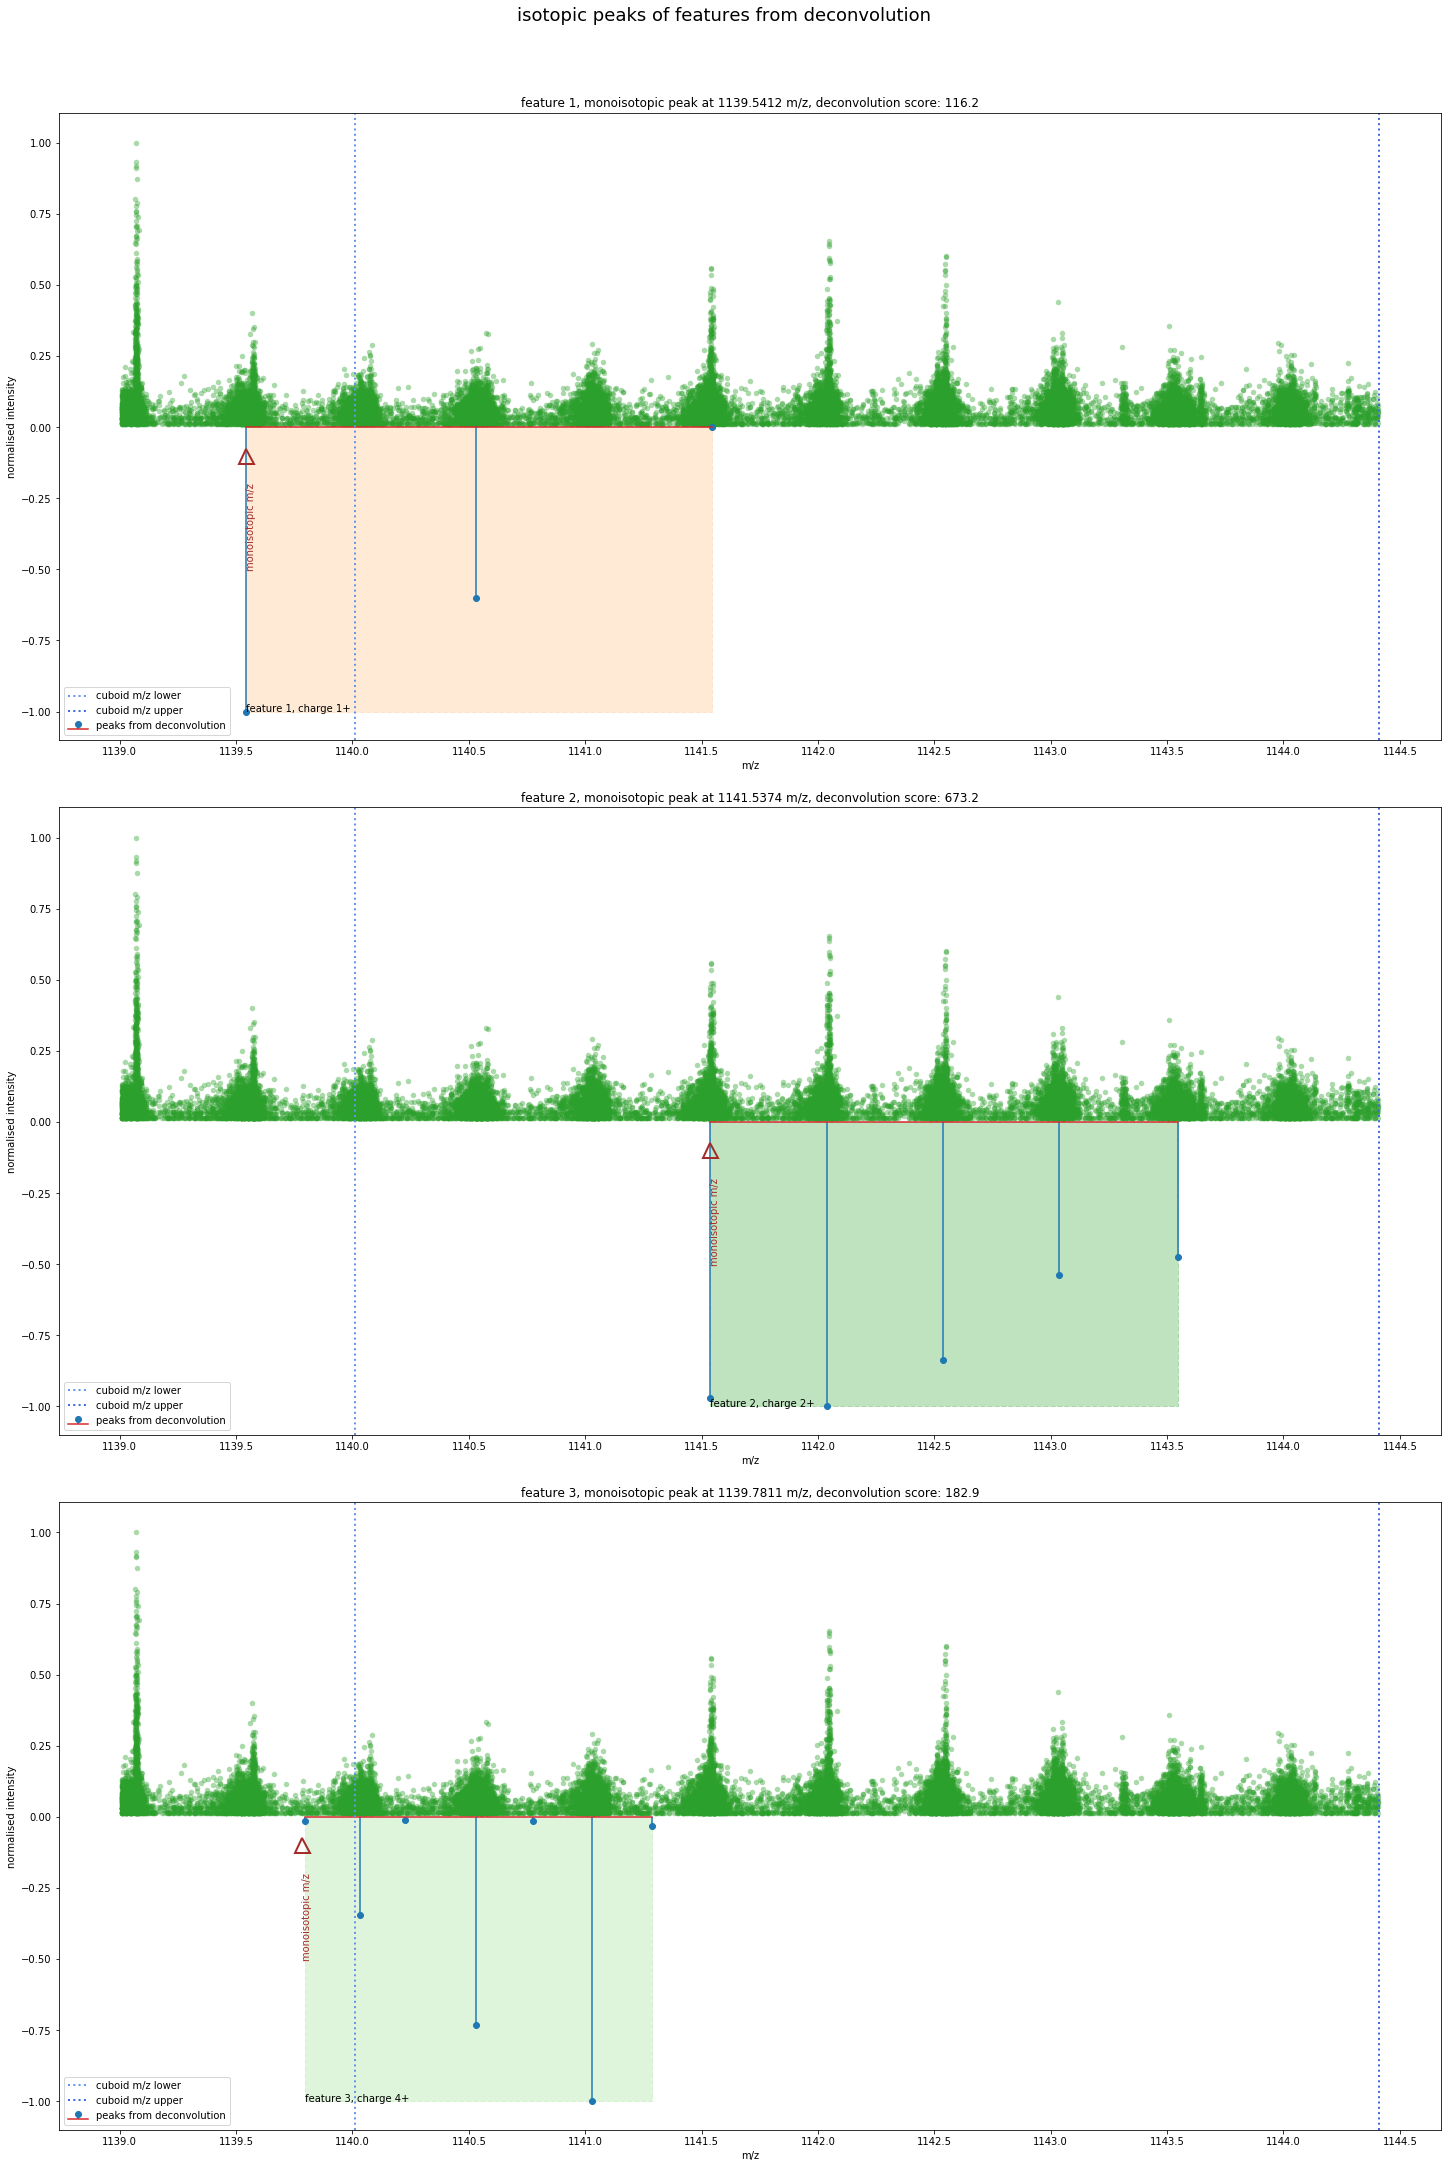

In [20]:
f, axarr = plt.subplots(nrows=len(features_fixed_bins_df), ncols=1, constrained_layout=True)
f.suptitle('isotopic peaks of features from deconvolution\n', fontsize=18)

f.set_figheight(len(features_fixed_bins_df)*10)
f.set_figwidth(20)

# plot the features derived from deconvoluting the peaks
for idx,row in enumerate(features_fixed_bins_df.itertuples()):
    if len(features_fixed_bins_df) > 1:
        ax = axarr[idx]  # row, column
    else:
        ax = axarr

    # plot the raw data
    ax.scatter(before_df.mz, before_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

    # plot the feature's bounding rectangle
    envelope = row.envelope
    feature_id = idx+1
    env_width = envelope[-1][0] - envelope[0][0]
    rect_colour = tableau20_mpl[idx+3]
    rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
    ax.add_patch(rect)
    ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(feature_id, row.charge))

    # determine the peaks from the envelope
    envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
    envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

    # plot the peaks from deconvolution
    markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, use_line_collection=True, label='peaks from deconvolution')
    
    # show the monoisotopic m/z determined by deconvolution
    ax.plot(row.mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
    text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
    ax.text(row.mono_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

    ax.axvline(x=metadata_s.window_mz_lower, linestyle=':', color='cornflowerblue', linewidth=2, label='cuboid m/z lower')
    ax.axvline(x=metadata_s.window_mz_upper, linestyle=':', color='royalblue', linewidth=2, label='cuboid m/z upper')

    nearest = 0.5
    range_l = round(before_df.mz.min() / nearest) * nearest
    range_u = round(before_df.mz.max() / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('m/z')
    ax.set_ylabel('normalised intensity')
    ax.legend(loc='best')
    
    ax.set_title('feature {}, monoisotopic peak at {} m/z, deconvolution score: {}'.format(feature_id, round(row.mono_mz,4), round(row.score,1)))

plt.show()

#### how gaussian is this peak?

In [21]:
window_width = 0.05
step_size = 0.01
peak_base_width = 0.1
half_peak_base_width = peak_base_width / 2

In [22]:
number_of_plots = len(features_fixed_bins_df)
number_of_columns = 2
number_of_rows = int(number_of_plots / number_of_columns)
if number_of_plots % number_of_columns != 0:
    number_of_rows += 1

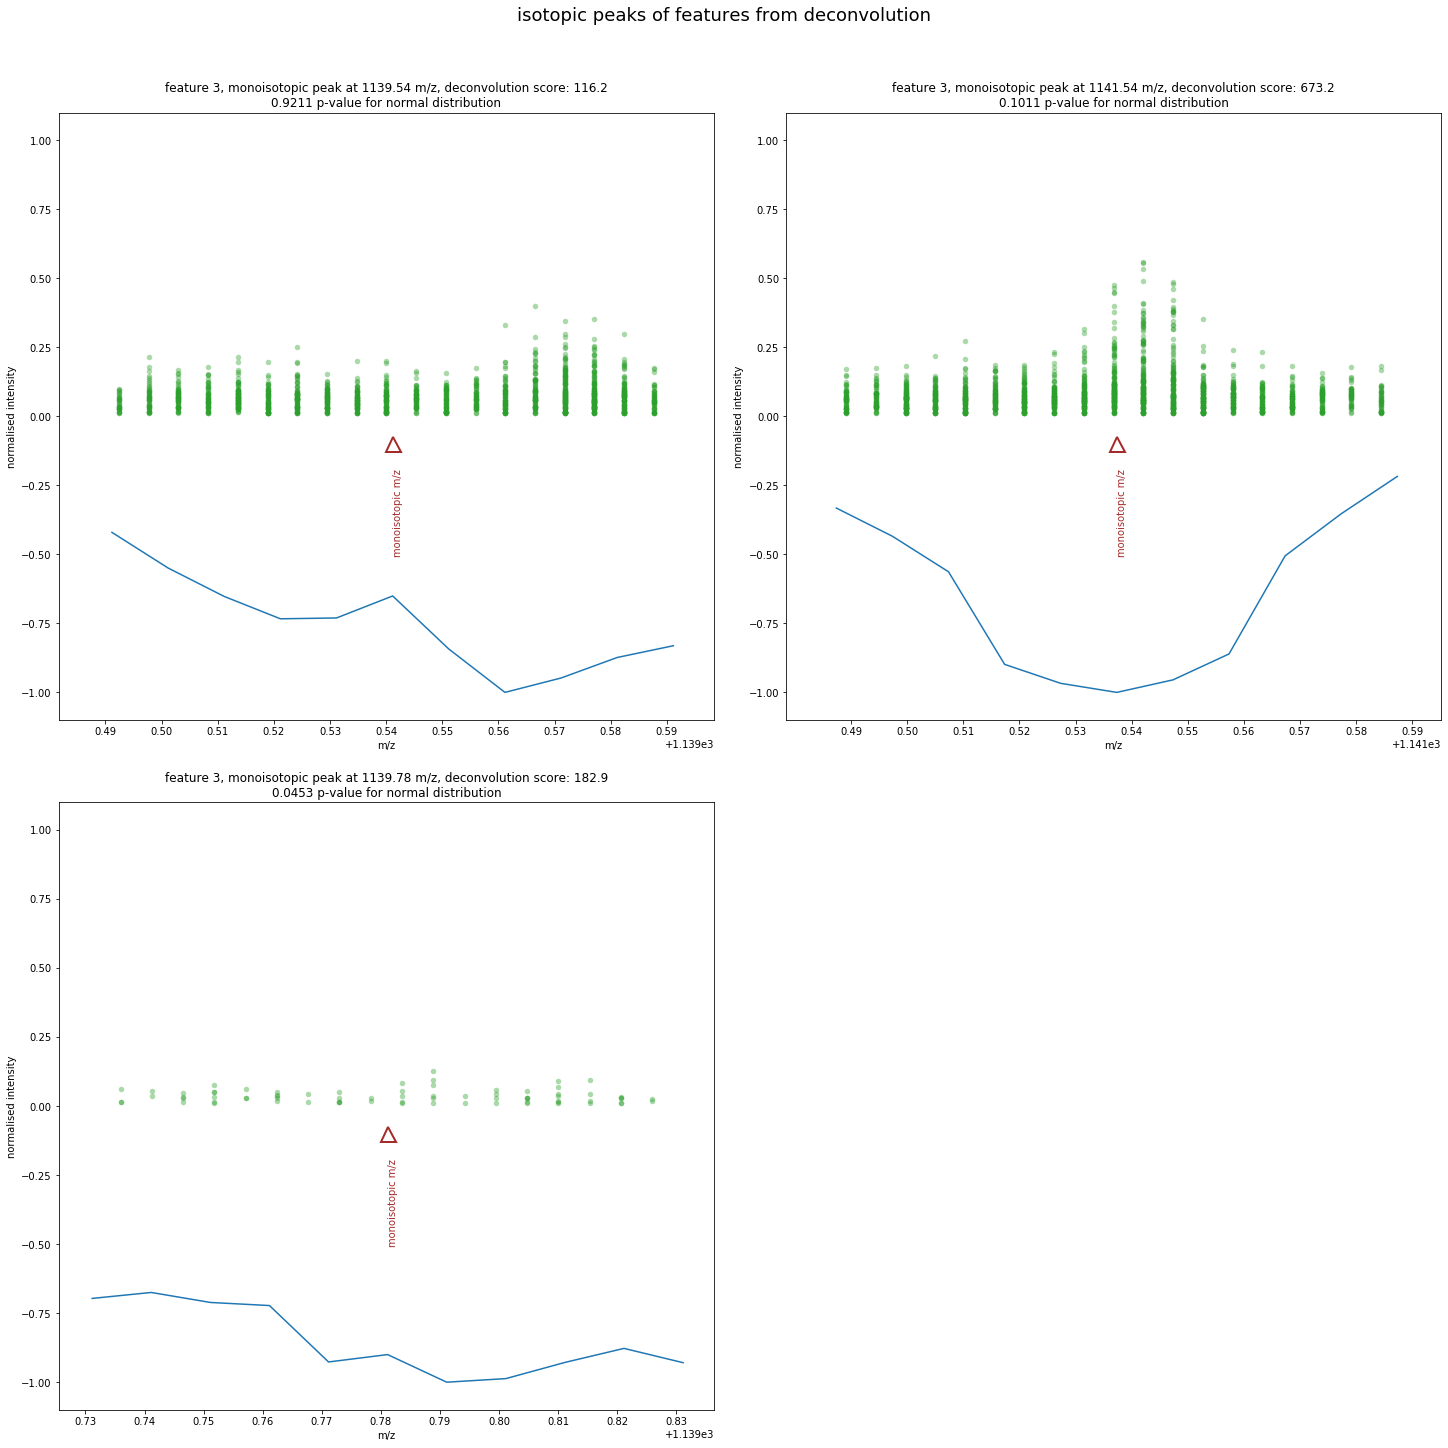

In [23]:
f, axarr = plt.subplots(nrows=number_of_rows, ncols=number_of_columns, constrained_layout=True)
f.suptitle('isotopic peaks of features from deconvolution\n', fontsize=18)

f.set_figheight(number_of_rows*10)
f.set_figwidth(20)

# turn off the axes if the last row is incomplete
if number_of_plots % number_of_columns != 0:
    axarr[-1, -1].axis('off')

# plot the features derived from deconvoluting the peaks
for idx,row in enumerate(features_fixed_bins_df.itertuples()):
    r = int(idx / number_of_columns)
    c = idx % number_of_columns
    
    ax = axarr[r,c]  # row, column

    # isolate the raw points for the monoisotopic peak
    peak_mz_lower = row.mono_mz - half_peak_base_width
    peak_mz_upper = row.mono_mz + half_peak_base_width
    peak_df = before_df[(before_df.mz >= peak_mz_lower) & (before_df.mz <= peak_mz_upper)]

    # sum the intensities in a sliding window across the peak
    window_intensities_l = []
    for mz_base in np.arange(peak_mz_lower,peak_mz_upper+step_size,step_size):
        window_intensity = before_df[(before_df.mz >= mz_base-window_width/2) & (before_df.mz <= mz_base+window_width/2)].intensity.sum()
        window_intensities_l.append((mz_base, window_intensity))
    window_intensities_df = pd.DataFrame(window_intensities_l, columns=['mz_base','intensity'])
    window_intensities_df['normalised_intensity'] = window_intensities_df.intensity / window_intensities_df.intensity.max()
    
    # plot the raw data
    ax.scatter(peak_df.mz, peak_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)
    
    # plot the sliding intensity sum
    ax.plot(window_intensities_df.mz_base, -window_intensities_df.normalised_intensity)

    # show the monoisotopic m/z determined by deconvolution
    ax.plot(row.mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
    text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
    ax.text(row.mono_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

    # how gaussian is this peak?
    stat, p = shapiro(window_intensities_df.intensity)
    
    # set up the tick marks
    nearest = 0.01
    range_l = round(peak_mz_lower / nearest) * nearest
    range_u = round(peak_mz_upper / nearest) * nearest
    ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

    ax.set_xlabel('m/z')
    ax.set_ylabel('normalised intensity')
    # ax.legend(loc='best')

    ax.set_ylim((-1.1,1.1))
    
    ax.set_title('feature {}, monoisotopic peak at {} m/z, deconvolution score: {}\n{} p-value for normal distribution'.format(feature_id, round(row.mono_mz,2), round(row.score,1), round(p, 4)))

plt.show()

#### check the feature's isotopic peak fit against the theoretical model

In [24]:
PROTON_MASS = 1.007276

In [25]:
# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
#
# source: Valkenborg et al, "A Model-Based Method for the Prediction of the Isotopic Distribution of Peptides", https://core.ac.uk/download/pdf/82021511.pdf
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    MAX_NUMBER_OF_SULPHUR_ATOMS = 3
    MAX_NUMBER_OF_PREDICTED_RATIOS = 6

    S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S0_r[1] = np.array([-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684])
    S0_r[2] = np.array([0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412])
    S0_r[3] = np.array([0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939])
    S0_r[4] = np.array([-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979])
    S0_r[5] = np.array([-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742])
    S0_r[6] = np.array([0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180])

    S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S1_r[1] = np.array([-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489])
    S1_r[2] = np.array([0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601])
    S1_r[3] = np.array([0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027])
    S1_r[4] = np.array([0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815])
    S1_r[5] = np.array([-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163])
    S1_r[6] = np.array([0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940])

    S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
    S2_r[1] = np.array([-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070])
    S2_r[2] = np.array([0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884])
    S2_r[3] = np.array([0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139])
    S2_r[4] = np.array([0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786])
    S2_r[5] = np.array([-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608])
    S2_r[6] = np.array([-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598])

    model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=np.ndarray)
    model_params[0] = S0_r
    model_params[1] = S1_r
    model_params[2] = S2_r

    ratio = None
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio


In [26]:
# determine the PHR error for peak 1 and peak 0 for each feature
for idx,row in enumerate(features_fixed_bins_df.itertuples()):
    # determine the peaks from the envelope
    envelope_df = pd.DataFrame(row.envelope, columns=['mz','intensity'])

    # calculate the actual and theoretical ratios
    observed_ratio = envelope_df.iloc[1].intensity / envelope_df.iloc[0].intensity
    monoisotopic_mass = (row.mono_mz * row.charge) - (PROTON_MASS * row.charge)
    if monoisotopic_mass <= 3915:
        expected_ratio = peak_ratio(monoisotopic_mass=monoisotopic_mass, peak_number=1, number_of_sulphur=0)
        print('feature {}, score {}, PHR actual {}, PHR theoretical {}'.format(idx+1, round(row.score,1), round(observed_ratio,2), round(expected_ratio,2)))
    else:
        print('feature {}, score {}, monoisotopic mass too high for the model'.format(idx+1, round(row.score,1)))

feature 1, score 116.2, PHR actual 0.6, PHR theoretical 0.61
feature 2, score 673.2, PHR actual 1.03, PHR theoretical 1.23
feature 3, score 182.9, monoisotopic mass too high for the model


In [27]:
features_fixed_bins_df

,mono_mz,second_peak_mz,intensity,score,SN,charge,envelope,neutral_mass
0,1139.541161,1140.532556,15881.400645,116.220281,13146.000000,1,"((1139.5412, 9915.00), (1140.5326, 5966.40), (...",1138.533884
1,1141.537352,1142.039419,175872.000000,673.160835,35174.400000,2,"((1141.5374, 44766.00), (1142.0394, 46049.00),...",2281.060152
2,1139.781147,1140.031986,48122.000000,182.904028,6874.571429,4,"((1139.7946, 360.00), (1140.0320, 7727.00), (1...",4555.095481


#### adjusting the monoisotopic peak intensity when underlying points are in saturation